### Data Collection

Tried loading the dataset using loadarff utility from scikit learn but it was failing as the original arff file contains categorical data as well and the provision to include that yet not been implemented in loadarff from scipy. So we are using custom way to read the file.

In [1]:
import re
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 500, 'display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

file = open('data.arff')
columns_raw = []
data = []
for line in file:
    if any((re.match(r'@relation', line), not line.strip())):
        continue
    if re.match(r'@attribute', line):
        c_dict = {}
        c_dict["name"] = line.split(' ')[1].strip()
        c_dict["type"] = line.split(' ')[2].strip()
        columns_raw.append(c_dict)
    else:
        if line.strip != '@data':
            data.append(line.strip().split(', '))
            
df = pd.DataFrame(data=data[1:], columns=[col["name"] for col in columns_raw])

### Exploratory Data Analysis

*1) Let's see what kind of values are there in our dataset*

In [2]:
df.head()

,Hour,Immobilized_bus,Broken_Truck,Vehicle_excess,Accident_victim,Running_over,Fire_vehicles,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
0,7:00,0.0,0.0,T,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1
1,7:30,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.6
2,8:00,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7
3,8:30,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,9:00,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1


In [3]:
df.dtypes

Hour                                     object
Immobilized_bus                          object
Broken_Truck                             object
Vehicle_excess                           object
Accident_victim                          object
Running_over                             object
Fire_vehicles                            object
Occurrence_involving_freight             object
Incident_involving_dangerous_freight     object
Lack_of_electricity                      object
Fire                                     object
Point_of_flooding                        object
Manifestations                           object
Defect_in_the_network_of_trolleybuses    object
Tree_on_the_road                         object
Semaphore_off                            object
Intermittent_Semaphore                   object
Slowness_in_traffic_percent              object
dtype: object

*'Hour', 'Vehicle_excess', & 'Fire_vehicles' are categorical columns so converting them to*
*numeric type using pandas "category"*

In [4]:
df["Vehicle_excess"].value_counts()

F    128
f      7
T      5
Name: Vehicle_excess, dtype: int64

In [5]:
df["Hour"] = df["Hour"].astype("category").cat.codes
df["Vehicle_excess"].value_counts()
df["Vehicle_excess"] = df["Vehicle_excess"].replace('f', 'F')
df[["Vehicle_excess", "Fire_vehicles"]] = df[["Vehicle_excess", "Fire_vehicles"]].astype("category")
df["Vehicle_excess"] = df["Vehicle_excess"].cat.codes
df["Fire_vehicles"] = df["Fire_vehicles"].cat.codes

In [6]:
df_original = df.copy()

*Before actually converting rest of the columns to float lets review kind of values we have for every *
and there percentage share*
*dropping the columns having percentage share of single value greater than 95% as they won't*
*contribute much to the slowness in traffic* 

In [7]:
for column in df.columns:
    print("-----", column, "-----")
    val = df[column].value_counts()/df.shape[0]*(100)
    if val.max() > 95:
        print(f"-----Dropping the {column}")
        df.drop([column], axis=1, inplace=True)

----- Hour -----
----- Immobilized_bus -----
----- Broken_Truck -----
----- Vehicle_excess -----
-----Dropping the Vehicle_excess
----- Accident_victim -----
----- Running_over -----
----- Fire_vehicles -----
-----Dropping the Fire_vehicles
----- Occurrence_involving_freight -----
-----Dropping the Occurrence_involving_freight
----- Incident_involving_dangerous_freight -----
-----Dropping the Incident_involving_dangerous_freight
----- Lack_of_electricity -----
----- Fire -----
-----Dropping the Fire
----- Point_of_flooding -----
----- Manifestations -----
----- Defect_in_the_network_of_trolleybuses -----
----- Tree_on_the_road -----
-----Dropping the Tree_on_the_road
----- Semaphore_off -----
----- Intermittent_Semaphore -----
-----Dropping the Intermittent_Semaphore
----- Slowness_in_traffic_percent -----


In [8]:
df.dtypes

Hour                                       int8
Immobilized_bus                          object
Broken_Truck                             object
Accident_victim                          object
Running_over                             object
Lack_of_electricity                      object
Point_of_flooding                        object
Manifestations                           object
Defect_in_the_network_of_trolleybuses    object
Semaphore_off                            object
Slowness_in_traffic_percent              object
dtype: object

*Great, now this will help us figure out all the outliers if any, to drop some of the non contributing columns and some wierd entries as well*
*Lets clear the data based on outputs from above cell*

In [9]:
# Running over has two absurd entries like "No" and "-1.0", converting both to 0.0  as we cann
# cannot afford lose as row because our dataset has only 140 rows
df["Running_over"] = df["Running_over"].replace('NO', 0.0)
df["Running_over"] = df["Running_over"].replace('-1.0', 0.0)

*Converting the columns to float type*

In [10]:
df =df.apply(pd.to_numeric)
df.dtypes

Hour                                        int8
Immobilized_bus                          float64
Broken_Truck                             float64
Accident_victim                          float64
Running_over                             float64
Lack_of_electricity                      float64
Point_of_flooding                        float64
Manifestations                           float64
Defect_in_the_network_of_trolleybuses    float64
Semaphore_off                            float64
Slowness_in_traffic_percent              float64
dtype: object

*Now lets figure out if we have some missing values*

In [11]:
total = df.isnull().sum().sort_values(ascending=False)
percent1 = df.isnull().sum()/df.isnull().count()*100
percent2 = (round(percent1, 1).sort_values(ascending=False))
missing_data = pd.concat([total, percent2], axis=1, keys=["Total", '%'])
missing_data

,Total,%
Defect_in_the_network_of_trolleybuses,2,1.4
Accident_victim,2,1.4
Semaphore_off,1,0.7
Slowness_in_traffic_percent,0,0.0
Manifestations,0,0.0
Point_of_flooding,0,0.0
Lack_of_electricity,0,0.0
Running_over,0,0.0
Broken_Truck,0,0.0
Immobilized_bus,0,0.0


*Replacing missing values with mean of the column and normalising the data so that our values will be in the range of 0-1*

In [12]:
x = [i for i in df]
AVG = df[x[-1]].mean()
df = df.replace(to_replace=np.nan, value=AVG)

# Normalisation
minmax = MinMaxScaler()
df[[i for i in df.iloc[:, 1:]]] = minmax.fit_transform(df[[i for i in df.iloc[:, 1:]]])

*Now we are down with limited columns 11 and lets do further EDA to see what all features we*
*are important*

*Plotting the pair plot to see the direct relationship between our target variable and other 
features*

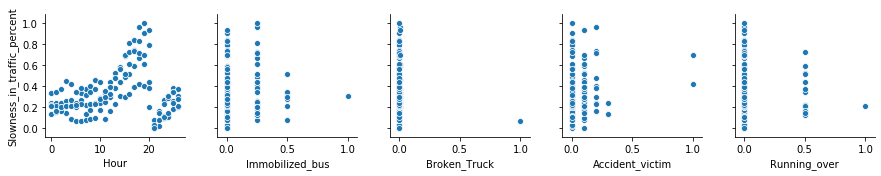

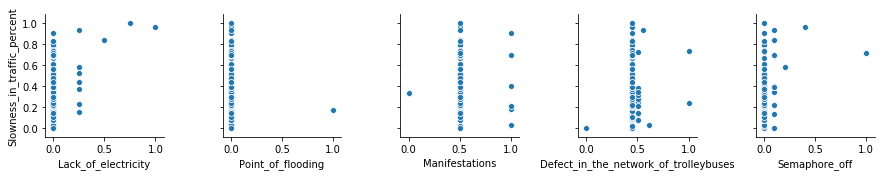

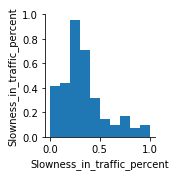

In [14]:
for i in range(0, len(df.columns), 5):
    sns.pairplot(data=df, 
                x_vars=df.columns[i:i+5],
                y_vars=["Slowness_in_traffic_percent"])

*From above plots its quite clear that "Hour" is very much in direct relation with Slowness
for specific time frame, but we can't say anything with confidence for rest of the features
Lets see individual features and see the relations the "Hour" & "Slowness in traffic"*

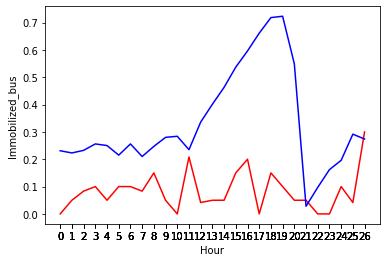

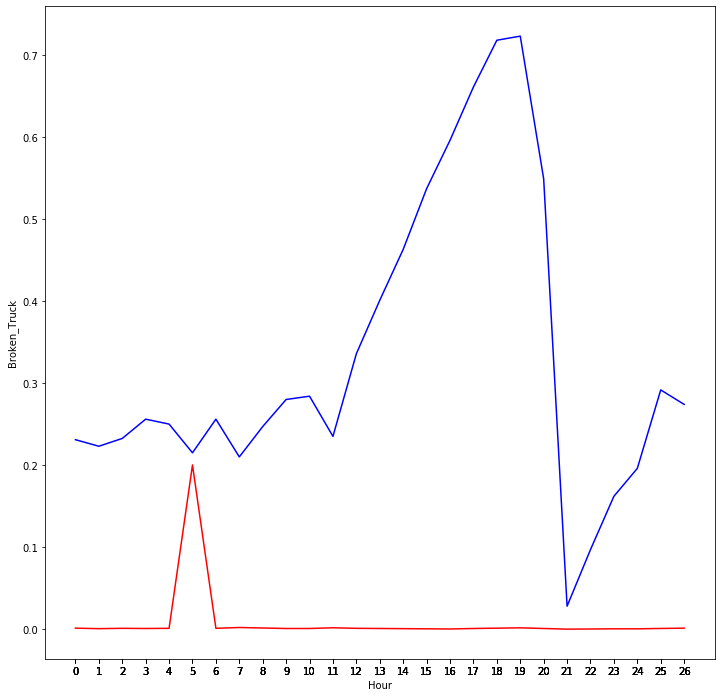

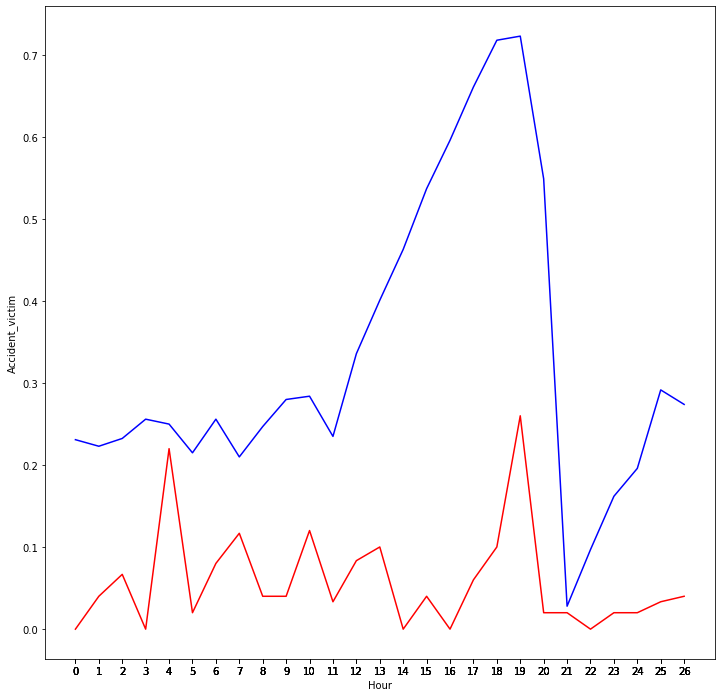

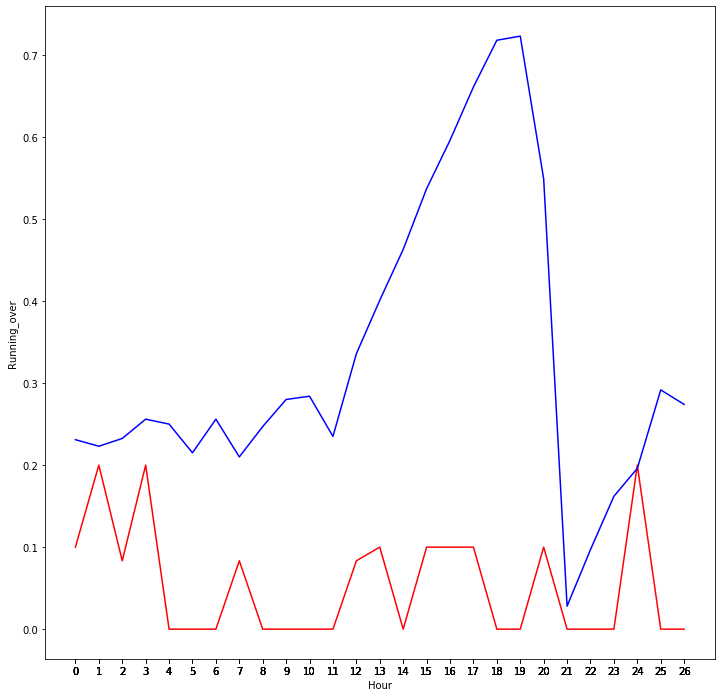

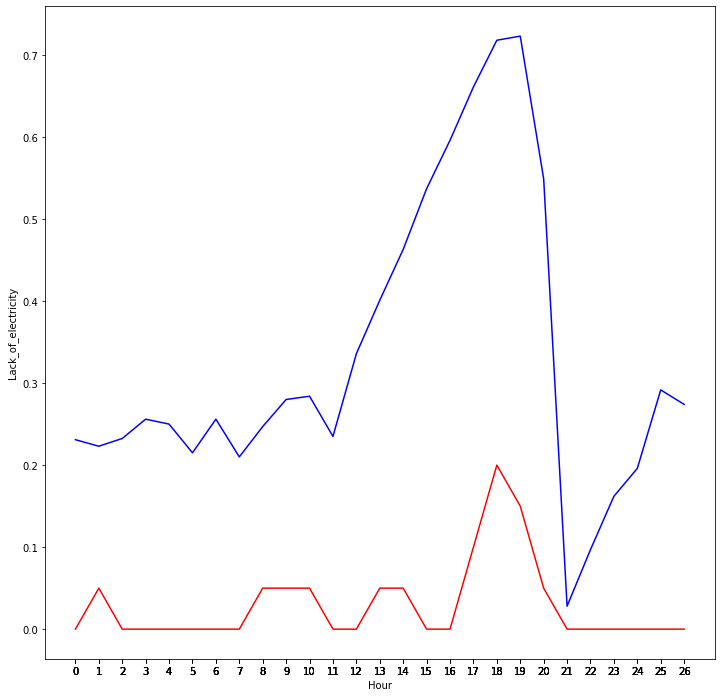

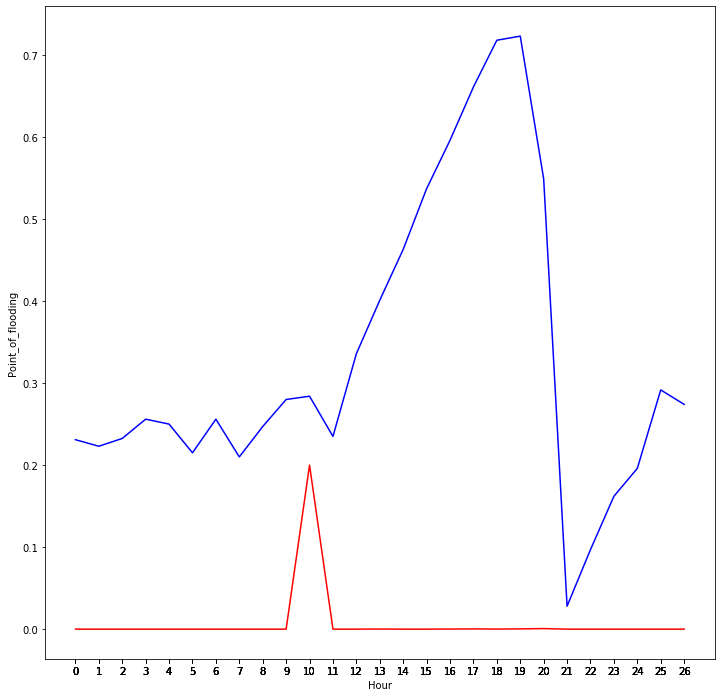

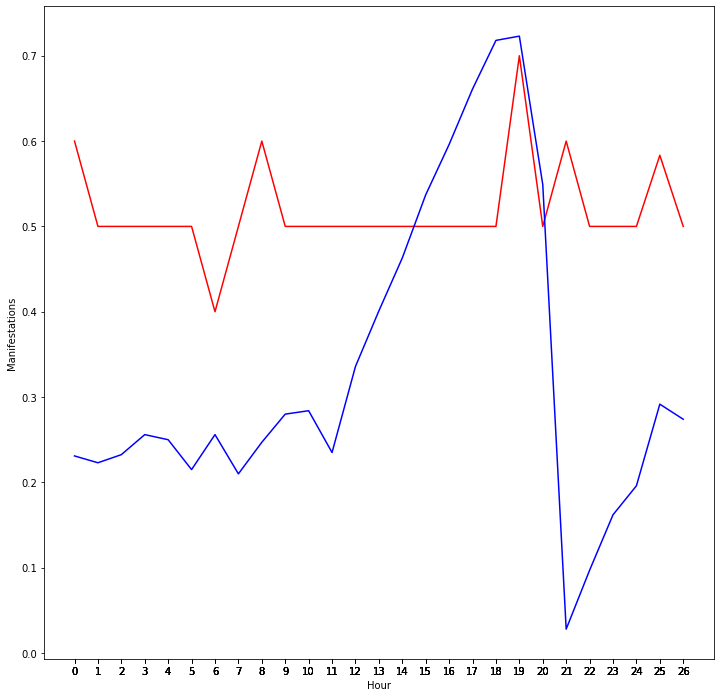

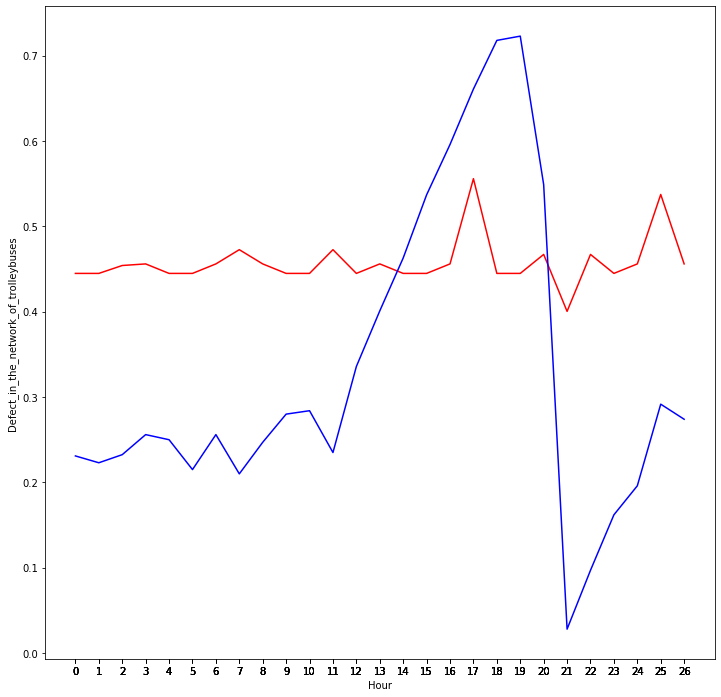

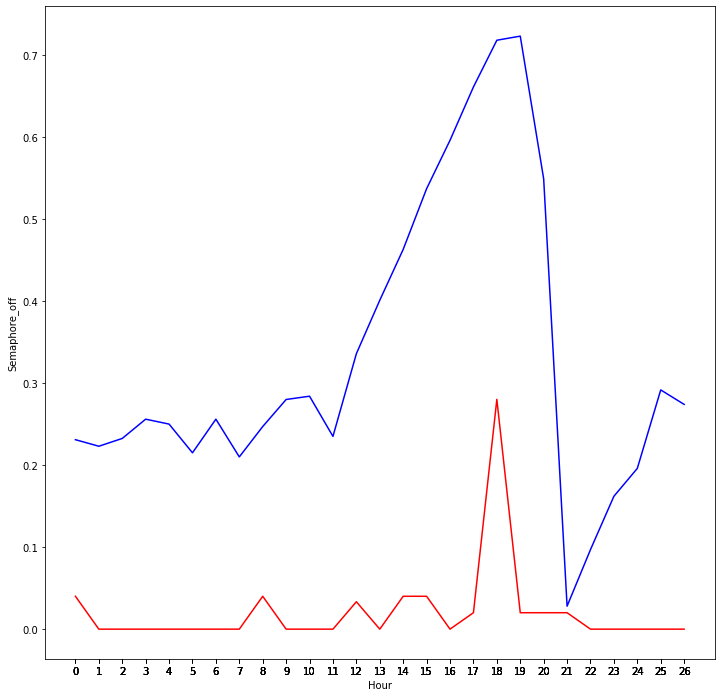

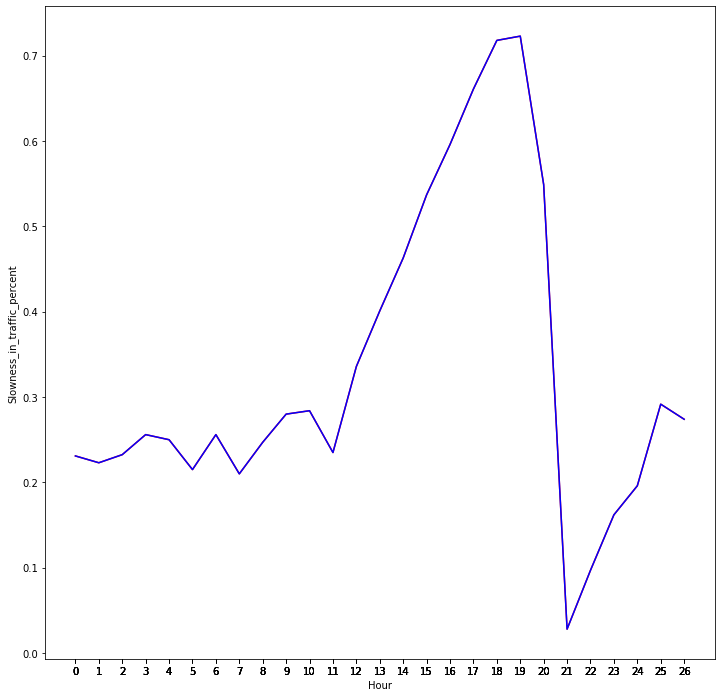

<Figure size 864x864 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
for column in df.columns:
    if column == 'Hour':
        continue
    #ax = plt.subplots(1,1,1)
    grouped_df = df.groupby("Hour")[column]
    grouped_df_slowness = df.groupby("Hour")["Slowness_in_traffic_percent"]
    plt.plot(grouped_df.agg('mean'), label=column, color='red')
    plt.xlabel("Hour")
    plt.ylabel(column)
    plt.plot(grouped_df_slowness.agg('mean'), label="Slowness in traffic", color='blue')
    plt.xticks(df["Hour"])
    plt.figure(figsize=(12, 12))

*From the above observation we can see*

### Modelling and prediction

*From our statistical analysis we saw "Hour", "Immobilised_bus" .......
has some effect of the slowness in traffic during specific timeframe
Now lets second our analysis by running couple of models and comparing the results*

In [20]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

#### Polynomial Regression

In [16]:
from sklearn.model_selection import train_test_split
df_original["Running_over"] = df_original["Running_over"].replace('NO', 0.0)
df_original["Running_over"] = df_original["Running_over"].replace('-1.0', 0.0)
df_original = df_original.apply(pd.to_numeric)
df_original.fillna(0.0, inplace=True)
y = df_original["Slowness_in_traffic_percent"]
x = df_original.drop(["Slowness_in_traffic_percent"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

In [ ]:
poly = PolynomialFeatures(degree=11)
poly_x = poly.fit_transform(x)

regressor = LinearRegression()
regressor.fit(poly_x, y)
y_pred  = regressor.predict(poly.fit_transform(x_test))

In [ ]:
print("Mean Squared Error", mse(y_test, y_pred))
errors = abs(y_pred-y_test)
print("Mean Absolute Error", round(np.mean(errors), 2))
print("R2 Score is: ", r2_score(y_test, y_pred))
print("Median Absolute Error", median_absolute_error(y_test, y_pred))

from sklearn.feature_selection import RFE
rfe = RFE(regressor, 5)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

In [125]:
x_train.columns

Index(['Hour', 'Immobilized_bus', 'Broken_Truck', 'Accident_victim',
       'Running_over', 'Lack_of_electricity', 'Point_of_flooding',
       'Manifestations', 'Defect_in_the_network_of_trolleybuses',
       'Semaphore_off'],
      dtype='object')

### Random Forest Regressor

In [23]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, max_depth = 2, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('R2 Score is: ', r2_score(y_test, y_pred))
print('Median Absolute Error is: ', median_absolute_error(y_test, y_pred))

Mean Absolute Error: 2.99
R2 Score is:  0.47160067559390884
Median Absolute Error is:  2.378292497587343


In [24]:
from sklearn.feature_selection import RFE
rfe = RFE(rf, 5)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True  True False False False False False False False  True False  True
 False  True False False False]
Feature Ranking: [ 1  1  2  7  6  4  3 12 13  1 11  1 10  1  9  5  8]


*Columns influencing slowness in traffic as per RandomForest Regressor*

In [43]:
x_train[x_train.columns[fit.support_]].columns

Index(['Hour', 'Immobilized_bus', 'Lack_of_electricity', 'Point_of_flooding',
       'Defect_in_the_network_of_trolleybuses'],
      dtype='object')